# COMP2611 Artificial Intelligence Coursework 1
### Darshan Sajeev () and Samantha Ramirez (201725731)

*Declaration A*

## Part A

### Implementation


In [1]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder
downloading bbSearch module
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0  46224      0 --:--:-- --:--:-- --:--:-- 46110
Loading bbSearch Version 2.1 (at 15:35, Thu 20 Feb)
Last module source code edit 9am Thursday 24th Feb 2022


Code from Search exercise 7. Creates the grids with their respective blocks and their respective colours

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [3]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

### Puzzle Test Cases

After some experimentation we decided to investigate the following cases of Sliding Block Puzzle. We chose a 4x4 grid for the smaller grid as well as an 7x6 grid for the second, larger grid. We placed the same blocks on both grids and the goal for both is to move the red L chaped block to the bottom left of both grid. 

In [4]:
small_initial = [[1,0,0,2],
         [1,1,0,0],
         [0,0,0,4],
         [3,3,0,4]]

small_goal = [[0,0,0,0],
         [0,0,0,0],
         [0,0,1,0],
         [0,0,1,1]]

large_initial = [[1,0,0,0,0,0,2],
         [1,1,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,4],
         [3,3,0,0,0,0,4]]


large_goal = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,1,0],
         [0,0,0,0,0,1,1]]

small_puzzle =  SlidingBlocksPuzzle( small_initial,  small_goal)
large_puzzle =  SlidingBlocksPuzzle( large_initial,  large_goal)

### Breadth First Search

The first test is to show how the size of the grids may effect the time it takes to complete the search as well as how the different search algorithms effect the time and path length. Originally, the large grid was of size 7x8 and we planned on setting the node limit to 5000 which passed for every small grid test. However, the large grid was too large for this small node limit so we increased the limit by 5000 each time and tested if the algorithm passed or failed. Eventually the programs failed as it approched to 50000 nodes. Therefore we reduced the grid size and set the node limit was 30000 for all the tests

Solve the following sliding blocks problem.
Get from this initial state:


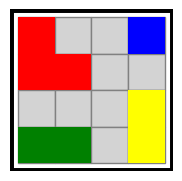

To a state incorporating the following block position(s):


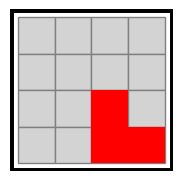

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


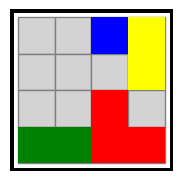

The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.1048 seconds

Solve the following sliding blocks problem.
Get from this initial state:


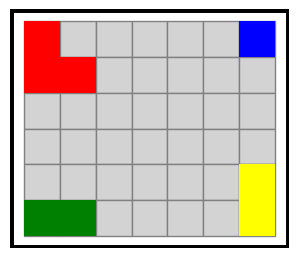

To a state incorporating the following block position(s):


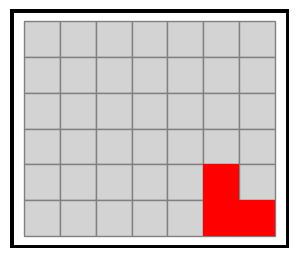

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


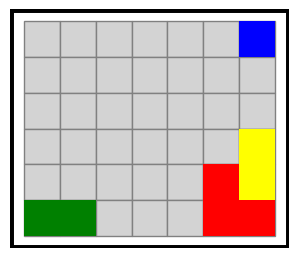

The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 9.2436 seconds



In [5]:
small_search = search( small_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_search = search( large_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)

### Depth First Search

This test is for Depth first search. The small gird passed successfully however, the larger grid did not so we increased the node limit to 35000 to see at what point it would pass.

Solve the following sliding blocks problem.
Get from this initial state:


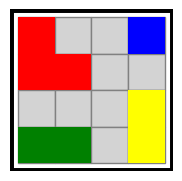

To a state incorporating the following block position(s):


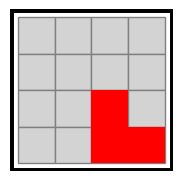

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)



:-)) *SUCCESS* ((-:

Path length = 78
Goal state is:


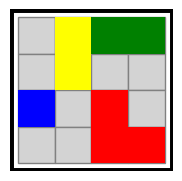

The action path to the solution is:
('yellow', 'up')
('yellow', 'left')
('yellow', 'up')
('green', 'up')
('green', 'right')
('green', 'right')
('green', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'left')
('yellow', 'up')
('green', 'up')
('green', 'left')
('yellow', 'down')
('yellow', 'down')
('green', 'down')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('green', 'left')
('green', 'up')
('yellow', 'down')
('yellow', 'down')
('yellow', 'left')
('green', 'down')
('blue', 'up')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('yellow', 'right')
('green', 'right')
('yellow', 'down')
('red', 'down')
('yellow', 'down')
('green', 'left')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('yellow', 'left')
('green', 'right')
('yellow', 'down')
('green', 'right')
('yellow', 'right')
('yellow', 'up')
('green', 'up')
('yellow', 'left')
('blue', 'up')
('green', 'down')
('blue', 'left')
('yellow', 'down')
('yellow', 'right')
('red', 'down')
('yellow', 'up')
('green', 'up')
('

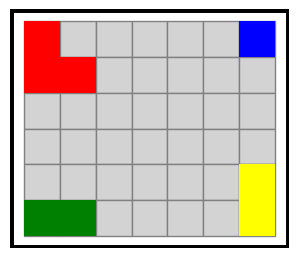

To a state incorporating the following block position(s):


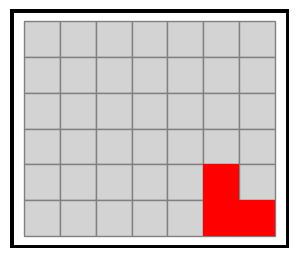

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...
!! Search node limit (30000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =    43931  (includes start)
Nodes discarded by loop_check  =    13930  (30001 distinct states added to queue)
Nodes tested (by goal_test)    =     3982  (all expanded)
Nodes left in queue            =    26018

Time taken = 5.3185 seconds

Solve the following sliding blocks problem.
Get from this initial state:


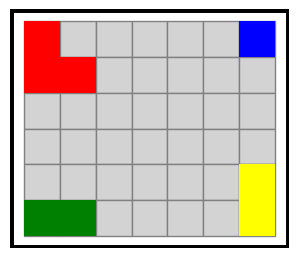

To a state incorporating the following block position(s):


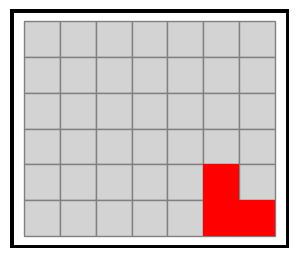

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 35000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 763
Goal state is:


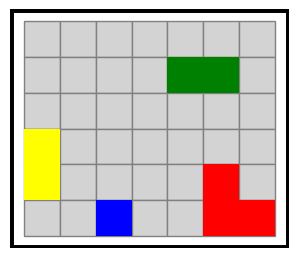

The action path to the solution is:
('green', 'right')
('red', 'down')
('blue', 'down')
('red', 'down')
('green', 'up')
('blue', 'up')
('green', 'right')
('yellow', 'up')
('blue', 'left')
('red', 'right')
('green', 'right')
('red', 'up')
('green', 'down')
('blue', 'right')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('red', 'left')
('blue', 'left')
('yellow', 'right')
('green', 'right')
('blue', 'left')
('red', 'up')
('yellow', 'left')
('yellow', 'down')
('red', 'down')
('yellow', 'left')
('yellow', 'down')
('blue', 'left')
('red', 'up')
('blue', 'left')
('red', 'up')
('yellow', 'up')
('yellow', 'right')
('yellow', 'up')
('red', 'right')
('green', 'up')
('blue', 'right')
('blue', 'right')
('green', 'down')
('blue', 'right')
('blue', 'right')
('yellow', 'left')
('green', 'left')
('blue', 'down')
('yellow', 'down')
('yellow', 'left')
('blue', 'down')
('yellow', 'left')
('yellow', 'left')
('yellow', 'down')
('green', 'right')
('red', 'down')
('yellow', 'left')
(

In [6]:
small_Df = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF2 = search( large_puzzle, 'DF/LIFO', 35000, loop_check=True, randomise=True, return_info=True)

This is the same as the depth first test but *randomise is true*.

Solve the following sliding blocks problem.
Get from this initial state:


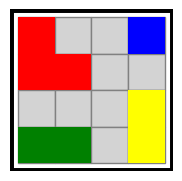

To a state incorporating the following block position(s):


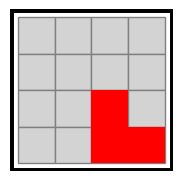

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 66
Goal state is:


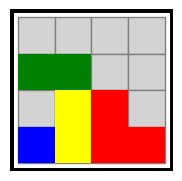

The action path to the solution is:
('blue', 'left')
('red', 'down')
('blue', 'down')
('yellow', 'up')
('blue', 'down')
('yellow', 'up')
('blue', 'right')
('red', 'up')
('green', 'right')
('blue', 'down')
('red', 'right')
('green', 'left')
('red', 'down')
('yellow', 'down')
('green', 'right')
('red', 'left')
('yellow', 'left')
('blue', 'up')
('blue', 'up')
('red', 'up')
('blue', 'up')
('green', 'right')
('blue', 'left')
('red', 'down')
('red', 'down')
('blue', 'right')
('yellow', 'right')
('red', 'up')
('green', 'left')
('green', 'left')
('red', 'right')
('red', 'up')
('green', 'right')
('green', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'left')
('blue', 'down')
('yellow', 'down')
('green', 'left')
('blue', 'down')
('red', 'right')
('yellow', 'down')
('green', 'down')
('red', 'right')
('blue', 'down')
('green', 'up')
('blue', 'left')
('yellow', 'left')
('green', 'up')
('blue', 'up')
('yellow', 'right')
('blue', 'left')
('blue', 'down')
('green', 'up')
('yellow', 'left')
('blue', 

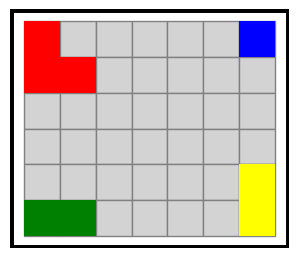

To a state incorporating the following block position(s):


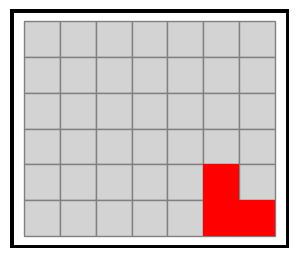

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 414
Goal state is:


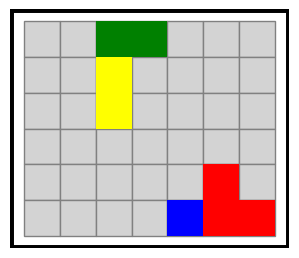

The action path to the solution is:
('yellow', 'left')
('red', 'down')
('red', 'down')
('red', 'right')
('yellow', 'left')
('yellow', 'up')
('green', 'right')
('red', 'up')
('red', 'up')
('red', 'right')
('blue', 'down')
('green', 'up')
('red', 'right')
('blue', 'left')
('yellow', 'left')
('green', 'left')
('blue', 'down')
('green', 'down')
('yellow', 'down')
('green', 'right')
('blue', 'up')
('blue', 'up')
('red', 'right')
('green', 'left')
('green', 'up')
('yellow', 'left')
('blue', 'right')
('red', 'left')
('green', 'up')
('green', 'right')
('red', 'right')
('yellow', 'right')
('red', 'down')
('green', 'left')
('blue', 'left')
('blue', 'left')
('yellow', 'right')
('red', 'down')
('blue', 'right')
('green', 'right')
('red', 'left')
('red', 'up')
('red', 'left')
('blue', 'down')
('blue', 'right')
('yellow', 'up')
('blue', 'down')
('yellow', 'left')
('blue', 'down')
('yellow', 'down')
('yellow', 'right')
('green', 'down')
('red', 'up')
('green', 'right')
('blue', 'down')
('blue', 'left

In [7]:
small_DFR = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)
large_DFR = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)

### Best First

We have now introduced the cost aspect of the search. This cost function is from Search Exercise 6

Solve the following sliding blocks problem.
Get from this initial state:


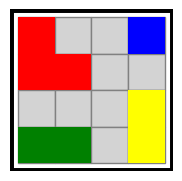

To a state incorporating the following block position(s):


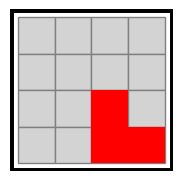

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


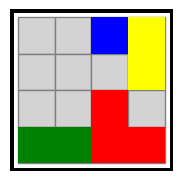

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.0948 seconds

Solve the following sliding blocks problem.
Get from this initial state:


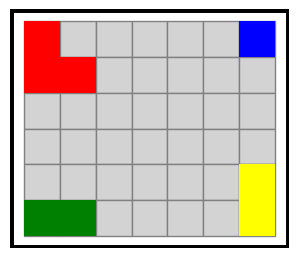

To a state incorporating the following block position(s):


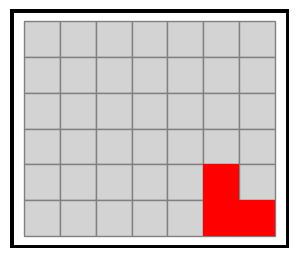

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


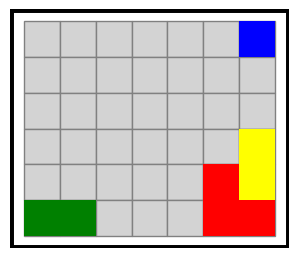

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 8.438 seconds



In [8]:
def cost(path, state):
        return len(path)

small_cost = search(small_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)
large_cost = search(large_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)

### A* Algorithm

This A* algorithm uses the cost function from before and now uses heuristics. This heuristic is from Search Exercise 7

Solve the following sliding blocks problem.
Get from this initial state:


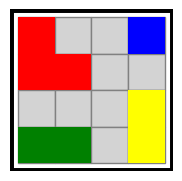

To a state incorporating the following block position(s):


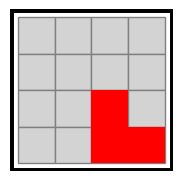

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


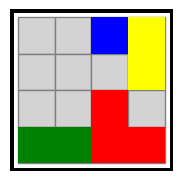

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'down')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1163  (includes start)
Nodes discarded by loop_check  =      860  (303 distinct states added to queue)
Nodes tested (by goal_test)    =      196  (195 expanded + 1 goal)
Nodes left in queue            =      107

Time taken = 0.0676 seconds

Solve the following sliding blocks problem.
Get from this initial state:


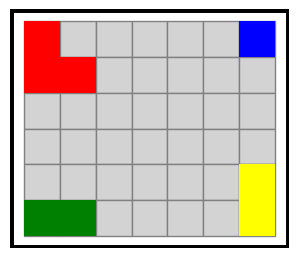

To a state incorporating the following block position(s):


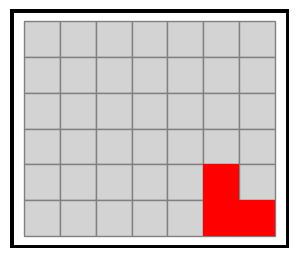

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


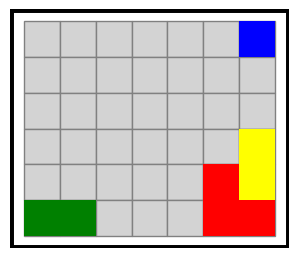

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    21361  (includes start)
Nodes discarded by loop_check  =    16783  (4578 distinct states added to queue)
Nodes tested (by goal_test)    =     2052  (2051 expanded + 1 goal)
Nodes left in queue            =     2526

Time taken = 0.8687 seconds



In [9]:
def red_right_heuristic(state):
    for row in state.blockstate:
      for i, col in enumerate(row):
          if col == 1:
            return 6-i

small_A = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)
large_A = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)


#### Heuristics

Continuing to look at the impact of heuristics within A* algorithm, we have chosen to look at the *Manhattan Distance Heuristic* which calculates the sum of horizontal and vertical distances of the block from goal state.

Solve the following sliding blocks problem.
Get from this initial state:


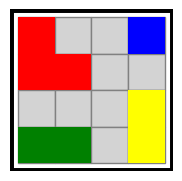

To a state incorporating the following block position(s):


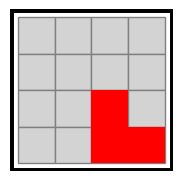

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=manhattan_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


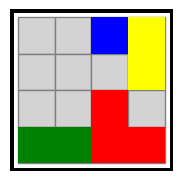

Cost of reaching goal: 7
The action path to the solution is:
('red', 'down')
('red', 'right')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =      151  (includes start)
Nodes discarded by loop_check  =       71  (80 distinct states added to queue)
Nodes tested (by goal_test)    =       29  (28 expanded + 1 goal)
Nodes left in queue            =       51

Time taken = 0.0301 seconds

Solve the following sliding blocks problem.
Get from this initial state:


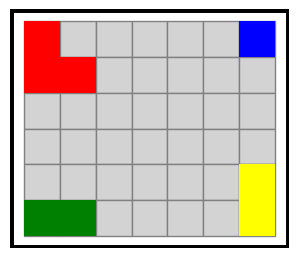

To a state incorporating the following block position(s):


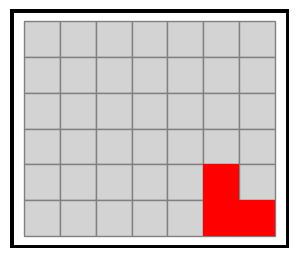

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=manhattan_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


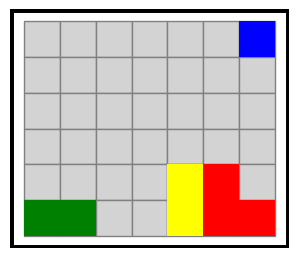

Cost of reaching goal: 11
The action path to the solution is:
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =      163  (includes start)
Nodes discarded by loop_check  =       43  (120 distinct states added to queue)
Nodes tested (by goal_test)    =       20  (19 expanded + 1 goal)
Nodes left in queue            =      100

Time taken = 0.0653 seconds



In [10]:
def manhattan_heuristic(state):
    goal_r, goal_c = len(state.blockstate) - 1, len(state.blockstate[0]) - 1  # Bottom-right corner
    
    total = 0
    for row in range(state.nrows):
        for col in range(state.ncols):
            if state.blockstate[row][col] == 1:  # Find red block tiles
                total += abs(goal_r - row) + abs(goal_c - col)
    
    return total

small_manhattan = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=manhattan_heuristic)
large_manhattan = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=manhattan_heuristic)

Another heuristic we wanted to test is the calculation of free space around the goal position, making use of Manhattan Distance.

Solve the following sliding blocks problem.
Get from this initial state:


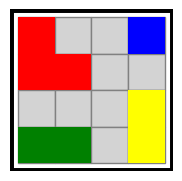

To a state incorporating the following block position(s):


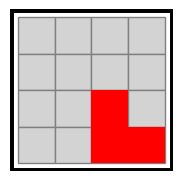

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=free_space_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


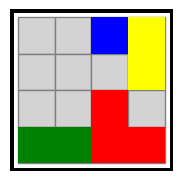

Cost of reaching goal: 7
The action path to the solution is:
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1006  (includes start)
Nodes discarded by loop_check  =      707  (299 distinct states added to queue)
Nodes tested (by goal_test)    =      169  (168 expanded + 1 goal)
Nodes left in queue            =      130

Time taken = 0.0501 seconds

Solve the following sliding blocks problem.
Get from this initial state:


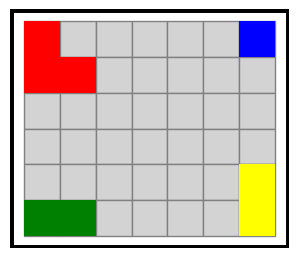

To a state incorporating the following block position(s):


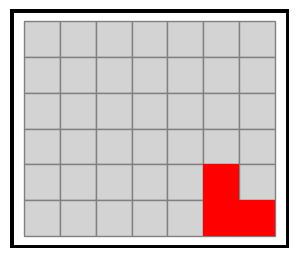

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=free_space_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


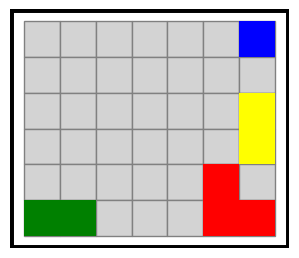

Cost of reaching goal: 11
The action path to the solution is:
('red', 'down')
('red', 'right')
('yellow', 'up')
('red', 'right')
('yellow', 'up')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'right')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    43571  (includes start)
Nodes discarded by loop_check  =    33701  (9870 distinct states added to queue)
Nodes tested (by goal_test)    =     4069  (4068 expanded + 1 goal)
Nodes left in queue            =     5801

Time taken = 1.6526 seconds



In [11]:
def free_space_heuristic(state):
    goal_r, goal_c = len(state.blockstate) - 1, len(state.blockstate[0]) - 1
    
    red_block_pos = None
    for r in range(len(state.blockstate)):
        for c in range(len(state.blockstate[r])):
            if state.blockstate[r][c] == 1:  # red block position
                red_block_pos = (r, c)
                break
        if red_block_pos:
            break
    
    # calculate the manhattan distance from red block to the goal
    red_r, red_c = red_block_pos
    manhattan_distance = abs(red_r - goal_r) + abs(red_c - goal_c)
    
    # count empty spaces around the goal
    empty_spaces = 0
    for dr in [-1, 0, 1]:  # check above, same row, and below
        for dc in [-1, 0, 1]:  # check left, same column, and right
            r, c = goal_r + dr, goal_c + dc
            if 0 <= r < len(state.blockstate) and 0 <= c < len(state.blockstate[0]):
                if state.blockstate[r][c] == 0:  # empty space
                    empty_spaces += 1 # more empty spaces = lower heuristic value
    
    return manhattan_distance - empty_spaces

small_free_space = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=free_space_heuristic)
large_free_space = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=free_space_heuristic)

This heuristic encourages the movement of the red block *diagonally* towards the goal state. This however does not take into account any puzzles in which an obstacle occurs in the path towards the goal.

Solve the following sliding blocks problem.
Get from this initial state:


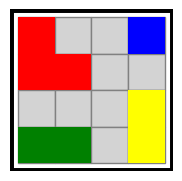

To a state incorporating the following block position(s):


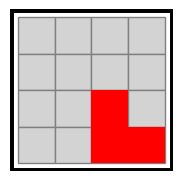

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_diagonal_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


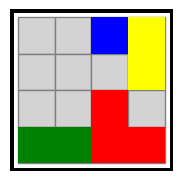

Cost of reaching goal: 7
The action path to the solution is:
('red', 'down')
('red', 'right')
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1236  (includes start)
Nodes discarded by loop_check  =      926  (310 distinct states added to queue)
Nodes tested (by goal_test)    =      200  (199 expanded + 1 goal)
Nodes left in queue            =      110

Time taken = 0.0619 seconds

Solve the following sliding blocks problem.
Get from this initial state:


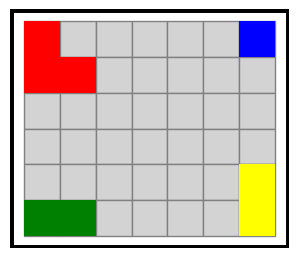

To a state incorporating the following block position(s):


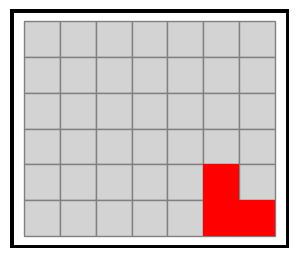

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_diagonal_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


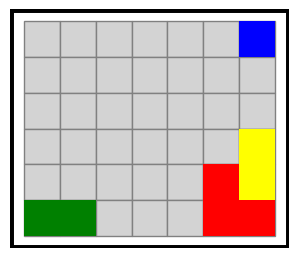

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    14834  (includes start)
Nodes discarded by loop_check  =    11555  (3279 distinct states added to queue)
Nodes tested (by goal_test)    =     1343  (1342 expanded + 1 goal)
Nodes left in queue            =     1936

Time taken = 0.591 seconds



In [12]:
def red_diagonal_heuristic(state):
    for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
            if col == 1:
                vertical = len(state.blockstate) - r
                horizontal = len(row) - c
                return vertical if vertical > horizontal else horizontal
    return 0

small_diagonal_right = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_diagonal_heuristic)
large_diagonal_right = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_diagonal_heuristic)

### Results

This table shows a summary of every test that was just performed and it is from Search Exercise 7. From the results, all the large tests failed with the low node limit of 5000. The A* algorithm included uses the red_right_heuristics - further results on heuristics below this.

In [13]:
TEST_RESULTS =[small_search, large_search, small_Df, large_DF, large_DF2, small_DFR, large_DFR,small_A, large_A]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    30000    Y      2134      137     0.1 
  1:    30000    Y    185417    10194     9.24 
  2:    30000    Y       472      192     0.06 
  3:    30000    !     43931    26018     5.32 
  4:    35000    Y      8697     6323     1.67 
  5:    30000    Y       400      176     0.06 
  6:    30000    Y      4684     3398     0.31 
  7:    30000    Y      1163      107     0.07 
  8:    30000    Y     21361     2526     0.87 


Here is a summary of results where heuristics were used.

In [14]:
TEST_RESULTS =[small_A, large_A, small_manhattan, large_manhattan, small_free_space, large_free_space, small_diagonal_right, large_diagonal_right]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    30000    Y      1163      107     0.07 
  1:    30000    Y     21361     2526     0.87 
  2:    30000    Y       151       51     0.03 
  3:    30000    Y       163      100     0.07 
  4:    30000    Y      1006      130     0.05 
  5:    30000    Y     43571     5801     1.65 
  6:    30000    Y      1236      110     0.06 
  7:    30000    Y     14834     1936     0.59 


### Observations

## Part B

### Scenario

.............

### Implementation

In [15]:
def parcel_heuristic(parcel):
    """Compute a score for each parcel to prioritize selection."""
    is_first_class = 1 if parcel.priority == 1 else 0
    is_stored_long = 1 if parcel.storage_days() >= 3 else 0
    return (10 * is_first_class) + (5 * is_stored_long)

In [46]:
from copy import deepcopy
from datetime import datetime, timedelta
import random

# Generate random date within the last 7 days
def generate_random_date():
    days_ago = random.randint(1, 7)
    return datetime.now() - timedelta(days=days_ago)

# Helper function to find the least full conveyor belt
def least_full_belt(conveyor_belts):
    return min(conveyor_belts, key=lambda cb: len(cb.parcels))

class Parcel:
    def __init__(self, parcel_id, date, priority):
        self.parcel_id = parcel_id
        self.date = datetime.strptime(date, '%Y-%m-%d') # convert string to datetime object
        self.priority = priority # 1 = first class, 2 = second class

    def __repr__(self):
        return f"({self.parcel_id}, {self.date.strftime('%Y-%m-%d')}, {self.priority})"
    
    def storage_days(self):
        return (datetime.now() - self.date).days

class Robot:
    def __init__(self, location, carried_parcels=None):
        if carried_parcels is None:
            carried_parcels = []
        self.location = location
        self.carried_parcels = carried_parcels

    def __repr__(self):
        return f"Robot at {self.location}, Carrying: {self.carried_parcels}"

class ConveyorBelt:
    def __init__(self, name):
        capacity = 100
        self.name = name
        self.parcels = []
        self.initial_capacity = capacity
        self.capacity = capacity

    def __repr__(self):
        return f"{self.name}: {self.parcels}, Capacity: {self.capacity}%"
    
    def add_parcel(self, parcel):
        """Add a parcel to the conveyor if there's space."""
        if self.capacity > 0:
            self.parcels.append(parcel)
            self.capacity -= int(self.initial_capacity * 0.1)  # decrease capacity by 10% of the initial capacity
        else:
            print(f"{self.name} is full! Cannot add {parcel.parcel_id}.")
    

class State:
    def __init__(self, robot, conveyor_belts, storage_room):
        self.robot = robot
        self.conveyor_belts = conveyor_belts
        self.storage_room = storage_room


    def __repr__(self):
        return f"Robot: {self.robot}, Storage: {self.storage_room}, Belts: {self.conveyor_belts}, Carried: {self.carried_parcels}"
    

# randomised parcels
STORAGE_ROOM = [
    Parcel(str(i), generate_random_date().strftime('%Y-%m-%d'), random.choice([1, 2]))
    for i in range(101, 133)
]

CONVEYOR_BELTS = [
    ConveyorBelt('conveyorA'),
    ConveyorBelt('conveyorB'),
    ConveyorBelt('conveyorC')
]

class RobotWorker(SearchProblem):
    def __init__(self, state, remaining_parcels):
        self.initial_state = state
        self.remaining_parcels = remaining_parcels

    # def possible_actions(self, state):
    #     actions = []

    #     # pick up parcels from storage using heuristic
    #     if state.robot.location == 'storage room' and (len(state.robot.carried_parcels) == 0):
    #         sorted_parcels = sorted(state.storage_room, key=parcel_heuristic, reverse=True)
    #         for i in range(0, len(sorted_parcels)-1):
    #             if i < 5:
    #                 actions.append(("pick up", sorted_parcels[i]))

    #     # drop off parcels at conveyor belts
    #     for parcel in state.robot.carried_parcels:
    #         least_full = least_full_belt(state.conveyor_belts)
    #         if least_full.capacity > 0:
    #             print(f"\nMoving parcel {parcel.parcel_id} (Priority: {parcel.priority}, Date: {parcel.date}) to {least_full.name}")
    #             state.storage_room.remove(parcel)  # Remove parcel from storage
    #             least_full.add_parcel(parcel)  # Add parcel to the conveyor
    #         else:
    #             print(f"!!!All conveyors are full!!! Returning parcel {parcel.parcel_id} to storage.")
    #             state.storage_room.append(parcel)  # Return parcel to storage if all belts are full

    #     # move between locations
    #     for cb in state.conveyor_belts:
    #         actions.append(("move to", cb.name))
    #     actions.append(("move to", 'storage room'))

    #     return actions
    
    def possible_actions(self, state):
        actions = []

        # pick up parcels from storage using heuristic
        if state.robot.location == 'storage room' and (len(state.robot.carried_parcels) < 5):
            sorted_parcels = sorted(state.storage_room, key=parcel_heuristic, reverse=True)
            for i in range(min(5, len(sorted_parcels))):  # Limit to picking up up to 5 parcels
                actions.append(("pick up", sorted_parcels[i]))

        # drop off parcels at conveyor belts
        for parcel in state.robot.carried_parcels:
            least_full = least_full_belt(state.conveyor_belts)
            if least_full.capacity > 0:
                actions.append(("drop off", parcel))  # drop off parcel at the least full conveyor belt

        # move between locations (storage room to conveyors)
        if state.robot.location == 'storage room':
            for cb in state.conveyor_belts:
                actions.append(("move to", cb.name))  # move to conveyor belts
        elif state.robot.location in [cb.name for cb in state.conveyor_belts]:
            actions.append(("move to", 'storage room'))  # move back to storage room

        return actions


    # def successor(self, state, action):
    #     next_state = deepcopy(state)
    #     act, target = action
        
    #     if act == "pick up":
    #         next_state.robot.carried_parcels.append(target)
    #         # next_state.storage_room.remove(target)
    #         if target.parcel_id in [p.parcel_id for p in state.storage_room]:
    #             state.storage_room.remove(target)
    #         else:
    #             print(f"Parcel {target.parcel_id} not in storage.")
    #         print(f"\nRobot picks up parcel {target.parcel_id} from storage.")

    #     elif act == "drop off":
    #         next_state.robot.carried_parcels.remove(target)
    #         best_belt = least_full_belt(next_state.conveyor_belts)
    #         if best_belt.add_parcel(target):
    #             print(f"\nRobot drops off parcel {target.parcel_id} at {best_belt.name}.")
    #         else:
    #             print(f"\nAll conveyors full! Returning {target.parcel_id} to storage.")
    #             next_state.storage_room.add(target)

    #     elif act == "move to":
    #         next_state.robot.location = target
    #         print(f"\nRobot moves to {target}.")

    #     return next_state
    
    def successor(self, state, action):
        next_state = deepcopy(state)
        act, target = action

        print(STORAGE_ROOM)
        
        if act == "pick up":
            matching_parcel = next((p for p in next_state.storage_room if p.parcel_id == target.parcel_id), None)
            if matching_parcel:
                next_state.robot.carried_parcels.append(matching_parcel)  # Append, not overwrite
                next_state.storage_room.remove(matching_parcel)  # Remove from storage
                print(f"\nRobot picks up parcel {matching_parcel.parcel_id} from storage.")
                print(f"Updated carried parcels: {[p.parcel_id for p in next_state.robot.carried_parcels]}")
                print(f"Remaining in storage: {[p.parcel_id for p in next_state.storage_room]}")
            else:
                print(f"Parcel {target.parcel_id} not found in storage.")


        elif act == "drop off":
            next_state.robot.carried_parcels.remove(target)
            best_belt = least_full_belt(next_state.conveyor_belts)
            if best_belt.add_parcel(target):
                print(f"\nRobot drops off parcel {target.parcel_id} at {best_belt.name}.")
            else:
                print(f"All conveyors are full! Returning {target.parcel_id} to storage.")
                next_state.storage_room.append(target)  # Return to storage if no space

        elif act == "move to":
            next_state.robot.location = target
            print(f"\nRobot moves to {target}.")

        return next_state
    

    def goal_test(self, state):
        if self.remaining_parcels == 0:
            return True
        else: 
            return False
        

    def display_state(self, state):
        print("Robot location:",state.robot.location)


In [48]:
rob = Robot('storage room', None)
state = State(rob, CONVEYOR_BELTS, STORAGE_ROOM)
RW_PROBLEM = RobotWorker(state, 0)

poss_acts = RW_PROBLEM.possible_actions(RW_PROBLEM.initial_state)
poss_acts

for acts in poss_acts:
    next_state = RW_PROBLEM.successor(RW_PROBLEM.initial_state, acts)
    RW_PROBLEM.display_state(next_state)
    print()

# search(RW_PROBLEM, 'BF/FIFO', 10000, loop_check=True)

# # sorted via heuristic
# sorted_parcels = sorted(STORAGE_ROOM, key=parcel_heuristic, reverse=True)
# print("Initial Parcel Order:", [p.parcel_id for p in sorted_parcels])

# # assign parcels to the conveyor belts
# for parcel in sorted_parcels:
#     # find most available capacity
#     least_full = least_full_belt(CONVEYOR_BELTS)
#     print(f"-" * 50)

#     # check if current conveyor has capacity
#     if least_full.capacity > 0:
#         print(f"\nMoving parcel {parcel.parcel_id} (Priority: {parcel.priority}, Date: {parcel.date}) to {least_full.name}")
#         STORAGE_ROOM.remove(parcel)  # Remove parcel from storage
#         least_full.add_parcel(parcel)  # Add parcel to the conveyor
#     else:
#         print(f"!!!All conveyors are full!!! Returning parcel {parcel.parcel_id} to storage.")
#         STORAGE_ROOM.append(parcel)  # Return parcel to storage if all belts are full


#     #current state of conveyor belts
#     for belt in CONVEYOR_BELTS:
#         print(f"{belt.name} contents: {[f'({p.parcel_id}, {p.date}, {p.priority})' for p in belt.parcels]} Capacity: {belt.capacity}%")

#     # remaining parcels in storage
#     print("Remaining in Storage:", [p.parcel_id for p in STORAGE_ROOM],"\n")

# # output final state
# print("\n\nFinal Parcel States:")
# for belt in CONVEYOR_BELTS:
#     print(f"{belt.name}: {[p.parcel_id for p in belt.parcels]}")
# print("Remaining in Storage:", [p.parcel_id for p in STORAGE_ROOM],"\n")


[(101, 2025-02-18, 2), (102, 2025-02-15, 1), (103, 2025-02-19, 1), (104, 2025-02-13, 2), (105, 2025-02-16, 1), (106, 2025-02-17, 1), (107, 2025-02-17, 1), (108, 2025-02-18, 1), (109, 2025-02-17, 1), (110, 2025-02-13, 1), (111, 2025-02-13, 1), (112, 2025-02-14, 1), (113, 2025-02-19, 1), (114, 2025-02-16, 2), (115, 2025-02-17, 2), (116, 2025-02-19, 2), (117, 2025-02-17, 1), (118, 2025-02-18, 2), (119, 2025-02-19, 1), (120, 2025-02-19, 1), (121, 2025-02-18, 2), (122, 2025-02-18, 2), (123, 2025-02-18, 2), (124, 2025-02-19, 1), (125, 2025-02-13, 2), (126, 2025-02-13, 2), (127, 2025-02-18, 1), (128, 2025-02-13, 1), (129, 2025-02-16, 2), (130, 2025-02-19, 1), (131, 2025-02-18, 1), (132, 2025-02-16, 2)]

Robot picks up parcel 102 from storage.
Updated carried parcels: ['102']
Remaining in storage: ['101', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '1

### Heuristics

### Results

### Key Findings